In [1]:
# Mount drive
import os
from google.colab import drive
%cd /content
drive.mount('/content/drive', force_remount=True)
%cd 'drive/My Drive/Colab Notebooks/NLP/project/code'
%ls -l
print(os.listdir())

/content
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/NLP/project/code
total 3562
-rw------- 1 root root 109039 May 10 14:28 Benchmark_embeddings_advanced.ipynb
-rw------- 1 root root 318699 May 14 16:26 Benchmark_embeddings.ipynb
-rw------- 1 root root   3534 Apr 22 16:32 cleaning.py
-rw------- 1 root root 121164 May 15 14:58 combine_features.ipynb
-rw------- 1 root root   4341 May 13 18:02 compute_embeddings.py
-rw------- 1 root root  17705 May 14 19:36 MaLSTM_model.ipynb
-rw------- 1 root root 363996 May  9 10:48 master.zip
-rw------- 1 root root 363996 May  9 10:49 master.zip.1
-rw------- 1 root root 363996 May  9 10:51 master.zip.2
-rw------- 1 root root   4528 May 14 12:49 modeling.py
drwx------ 2 root root   4096 May  3 09:43 __pycache__/
-rw------- 1 root root  21800 Apr 25 09:06 pytorch_tuto.ipynb
drwx------ 2 root root   4096 May  1 16:25 sent2vec-master/
-rw------- 1 root root 926824 May 10 10:38 test.h5
-rw------- 1 root root   4912 May 13 18:58 transfo

In [2]:
! pip install gensim==3.8.0
! pip install fuzzywuzzy
! pip install python-Levenshtein

In [3]:
from sklearn.metrics import log_loss, accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import numpy as np
import random
import re
import time
from string import punctuation
import scipy.io
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import gc

import pickle

def save_pickle(filename, reviews_tokenized):
  with open(filename, 'wb') as f:
    pickle.dump(reviews_tokenized, f)

def load_pickle(filename):
  with open(filename, 'rb') as f:
    x = pickle.load(f)
  return x

import transform_dataset
import compute_embeddings
import modeling

print(gensim.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
3.8.0


In [0]:
questions1, questions2, is_duplicates = transform_dataset.clean_quora()
# cleaned_questions1, cleaned_questions2, cleaned_is_duplicates = transform_dataset.clean_quora(output='tokenized_list')

# cleaned_questions1 = load_pickle('../embeddings/tokenizer2_questions1')
# cleaned_questions2 = load_pickle('../embeddings/tokenizer2_questions2')

cleaned_questions1 = load_pickle('../data/tokenizer2_questions1')
cleaned_questions2 = load_pickle('../data/tokenizer2_questions2')

labels = np.array(is_duplicates)

In [0]:
def get_features(embs1, embs2):
  return np.concatenate((embs1, embs2, np.abs(embs2-embs1)), axis=1)
  
def calculate_features_from_embeddings(path, embedding1_file, embedding2_file):
    embs1 = np.load(os.path.join(path, embedding1_file))
    embs2 = np.load(os.path.join(path, embedding2_file))
    return calculate_cosine(embs1, embs2)

def calculate_cosine(embs1, embs2):
    return (embs1 * embs2).sum(axis=1)/(np.linalg.norm(embs1, axis=1) * np.linalg.norm(embs2, axis=1))

def jaccard_type_feature(count1, count2, eps=1e-12):
  features = (count1.multiply(count2 != 0) + count2.multiply(count1 != 0)).sum(axis=1)
  features = features / (count1.sum(axis=1) + count2.sum(axis=1) + eps)
  return features

# Collect features

## Sentence embedding features

In [0]:
from sklearn.model_selection import train_test_split
train_index, valid_index, _, _ = train_test_split(np.arange(len(questions1)), labels, train_size = 0.7, random_state=42, shuffle=True, stratify=labels)

In [7]:
from sklearn.linear_model import LogisticRegression
import tensorflow
import tensorflow.keras as keras
from tensorflow.keras import layers
import keras.backend as K
import gc

def get_simple_nn_model(input_dim, hidden_sizes=[32, 16, 8]):
  model = keras.Sequential()
  for i, hidden in enumerate(hidden_sizes):
    if i==0:
      model.add(layers.Dense(hidden, activation='relu', input_shape=(input_dim, )))
    else:
      model.add(layers.Dense(hidden, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_crossentropy', 'accuracy'])

  return model

def learn_and_predict_(embs, labels, train_index, valid_index, model=LogisticRegression(), **params):
  X_train, X_valid = embs[train_index], embs[valid_index]
  y_train, y_valid = labels[train_index], labels[valid_index]

  if issubclass(type(model), (tensorflow.python.keras.engine.sequential.Sequential, tensorflow.keras.Model)):
      params['validation_data'] = (X_valid, y_valid)
      
  model.fit(X_train, y_train, **params)
  
  if hasattr(model, 'predict_proba'):
      proba_predictions_train = model.predict_proba(X_train)
      proba_predictions_valid = model.predict_proba(X_valid)
  else:
      proba_predictions_train = model.predict(X_train)
      proba_predictions_valid = model.predict(X_valid)
          
  if proba_predictions_train.shape[1]==2:
      predictions_train = proba_predictions_train.argmax(axis=1)
      predictions_valid = proba_predictions_valid.argmax(axis=1)
  else:
      predictions_train = proba_predictions_train >= 0.5
      predictions_valid = proba_predictions_valid >= 0.5

  loss_train = log_loss(y_train, proba_predictions_train)
  loss_valid = log_loss(y_valid, proba_predictions_valid)

  accuracy_train = accuracy_score(y_train, predictions_train)
  accuracy_valid = accuracy_score(y_valid, predictions_valid)

  f1_train = f1_score(y_train, predictions_train)
  f1_valid = f1_score(y_valid, predictions_valid)

  print({'loss':np.round(loss_train,2), 'accuracy':np.round(accuracy_train,2), 'f1':np.round(f1_train,2)})
  print({'loss':np.round(loss_valid,2), 'accuracy':np.round(accuracy_valid,2), 'f1':np.round(f1_valid,2)})

  features = np.zeros((len(train_index)+len(valid_index), proba_predictions_train.shape[1]))
  features[train_index] = proba_predictions_train
  features[valid_index] = proba_predictions_valid

  return features


def learn_and_predict(embs, labels, train_index, valid_index, model=LogisticRegression(), **params):
  # X_train, X_valid = embs[train_index], embs[valid_index]
  # y_train, y_valid = labels[train_index], labels[valid_index]

  # if issubclass(type(model), (tensorflow.python.keras.engine.sequential.Sequential, tensorflow.keras.Model)):
  #     params['validation_data'] = (X_valid, y_valid)
      
  model.fit(embs[train_index], labels[train_index], **params)
  
  if hasattr(model, 'predict_proba'):
      proba_predictions_train = model.predict_proba(embs[train_index])
      if issubclass(type(model), (tensorflow.python.keras.engine.sequential.Sequential, tensorflow.keras.Model)):
          K.clear_session()
          gc.collect()
      proba_predictions_valid = model.predict_proba(embs[valid_index])
      if issubclass(type(model), (tensorflow.python.keras.engine.sequential.Sequential, tensorflow.keras.Model)):
          K.clear_session()
          gc.collect()
  else:
      proba_predictions_train = model.predict(embs[train_index])
      if issubclass(type(model), (tensorflow.python.keras.engine.sequential.Sequential, tensorflow.keras.Model)):
          K.clear_session()
          gc.collect()
      proba_predictions_valid = model.predict(embs[valid_index])
      if issubclass(type(model), (tensorflow.python.keras.engine.sequential.Sequential, tensorflow.keras.Model)):
          K.clear_session()
          gc.collect()
          
  if proba_predictions_train.shape[1]==2:
      predictions_train = proba_predictions_train.argmax(axis=1)
      predictions_valid = proba_predictions_valid.argmax(axis=1)
  else:
      predictions_train = proba_predictions_train >= 0.5
      predictions_valid = proba_predictions_valid >= 0.5

  loss_train = log_loss(labels[train_index], proba_predictions_train)
  loss_valid = log_loss(labels[valid_index], proba_predictions_valid)

  accuracy_train = accuracy_score(labels[train_index], predictions_train)
  accuracy_valid = accuracy_score(labels[valid_index], predictions_valid)

  f1_train = f1_score(labels[train_index], predictions_train)
  f1_valid = f1_score(labels[valid_index], predictions_valid)

  print({'loss':np.round(loss_train,2), 'accuracy':np.round(accuracy_train,2), 'f1':np.round(f1_train,2)})
  print({'loss':np.round(loss_valid,2), 'accuracy':np.round(accuracy_valid,2), 'f1':np.round(f1_valid,2)})

  features = np.zeros((len(train_index)+len(valid_index), proba_predictions_train.shape[1]))
  features[train_index] = proba_predictions_train
  features[valid_index] = proba_predictions_valid

  return features

Using TensorFlow backend.


In [0]:
import gc

features = {}
features2 = {}
features3 = {}

precomputed_embeddings = ['SBERT_embeddings{}.npy', 'doc2vec_embeddings{}.npy', 'sent2vec_embeddings{}.npy']
for filename in precomputed_embeddings:
  print(filename.split('_')[0])
  embs1 = np.load(os.path.join('../embeddings/', filename.format(1)))
  embs2 = np.load(os.path.join('../embeddings/', filename.format(2)))
  features_ = get_features(embs1, embs2)

  print('step 1')
  cosine = calculate_cosine(embs1, embs2)
  features[filename.split('_')[0]] = cosine

# make space in RAM
  embs1 = None
  embs2 = None
  gc.collect()

  print('step 2')
  features2[filename.split('_')[0]] = learn_and_predict(features_, labels, train_index, valid_index, model=LogisticRegression())[:,-1]  

  print('step 3')
  model = get_simple_nn_model(features_.shape[1], hidden_sizes=[32, 16, 8])
  features3[filename.split('_')[0]] = learn_and_predict(features_, labels, train_index, valid_index, model=model, epochs=5, batch_size=64)[:,-1]  

SBERT


### To do it step by step for the big computations; not needed if above fit in RAM

In [0]:
features3 = {}

In [8]:
filename = 'SBERT_embeddings{}.npy'
embs1 = np.load(os.path.join('../embeddings/', filename.format(1)))
embs2 = np.load(os.path.join('../embeddings/', filename.format(2)))
features_ = get_features(embs1, embs2)

embs1 = None
embs2 = None
gc.collect()

print('step 3')
model = get_simple_nn_model(features_.shape[1], hidden_sizes=[32, 16, 8])
model.fit(features_[train_index], labels[train_index], epochs=5, batch_size=64)

proba_predictions_train = model.predict(features_[train_index])
if issubclass(type(model), (tensorflow.python.keras.engine.sequential.Sequential, tensorflow.keras.Model)):
    K.clear_session()
    gc.collect()
proba_predictions_valid = model.predict(features_[valid_index])
if issubclass(type(model), (tensorflow.python.keras.engine.sequential.Sequential, tensorflow.keras.Model)):
    K.clear_session()
    gc.collect()

if proba_predictions_train.shape[1]==2:
    predictions_train = proba_predictions_train.argmax(axis=1)
    predictions_valid = proba_predictions_valid.argmax(axis=1)
else:
    predictions_train = proba_predictions_train >= 0.5
    predictions_valid = proba_predictions_valid >= 0.5

loss_train = log_loss(labels[train_index], proba_predictions_train)
loss_valid = log_loss(labels[valid_index], proba_predictions_valid)

accuracy_train = accuracy_score(labels[train_index], predictions_train)
accuracy_valid = accuracy_score(labels[valid_index], predictions_valid)

f1_train = f1_score(labels[train_index], predictions_train)
f1_valid = f1_score(labels[valid_index], predictions_valid)

print({'loss':np.round(loss_train,2), 'accuracy':np.round(accuracy_train,2), 'f1':np.round(f1_train,2)})
print({'loss':np.round(loss_valid,2), 'accuracy':np.round(accuracy_valid,2), 'f1':np.round(f1_valid,2)})

feats = np.zeros((len(train_index)+len(valid_index), proba_predictions_train.shape[1]))
feats[train_index] = proba_predictions_train
feats[valid_index] = proba_predictions_valid

features3[filename.split('_')[0]] = feats[:,-1]  
np.save('../data/SBERT_predictions.npy', feats[:,-1])

step 3
Epoch 1/5
4422/4422 [==============================] - 22s 5ms/step - loss: 0.4286 - binary_crossentropy: 0.4286 - accuracy: 0.7936
Epoch 2/5
4422/4422 [==============================] - 23s 5ms/step - loss: 0.3940 - binary_crossentropy: 0.3940 - accuracy: 0.8147
Epoch 3/5
4422/4422 [==============================] - 23s 5ms/step - loss: 0.3780 - binary_crossentropy: 0.3780 - accuracy: 0.8242
Epoch 4/5
4422/4422 [==============================] - 22s 5ms/step - loss: 0.3674 - binary_crossentropy: 0.3674 - accuracy: 0.8296
Epoch 5/5
4422/4422 [==============================] - 20s 5ms/step - loss: 0.3593 - binary_crossentropy: 0.3593 - accuracy: 0.8334
{'loss': 0.35, 'accuracy': 0.84, 'f1': 0.79}
{'loss': 0.37, 'accuracy': 0.83, 'f1': 0.77}


In [12]:
filename = 'doc2vec_embeddings{}.npy'
model = compute_embeddings.Doc2Vec_model('../../../stage/embeddings/doc2vec/enwiki_dbow/doc2vec.bin')
# model = compute_embeddings.Doc2Vec_model('../embeddings/doc2vec/enwiki_dbow/doc2vec.bin')
model.load_model()
embs1 = model.calculate_embeddings(cleaned_questions1)
embs2 = model.calculate_embeddings(cleaned_questions2)
features_ = get_features(embs1, embs2)

embs1 = None
embs2 = None
gc.collect()

print('step 3')
model = get_simple_nn_model(features_.shape[1], hidden_sizes=[32, 16, 8])
model.fit(features_[train_index], labels[train_index], epochs=5, batch_size=64)

proba_predictions_train = model.predict(features_[train_index])
if issubclass(type(model), (tensorflow.python.keras.engine.sequential.Sequential, tensorflow.keras.Model)):
    K.clear_session()
    gc.collect()
proba_predictions_valid = model.predict(features_[valid_index])
if issubclass(type(model), (tensorflow.python.keras.engine.sequential.Sequential, tensorflow.keras.Model)):
    K.clear_session()
    gc.collect()

if proba_predictions_train.shape[1]==2:
    predictions_train = proba_predictions_train.argmax(axis=1)
    predictions_valid = proba_predictions_valid.argmax(axis=1)
else:
    predictions_train = proba_predictions_train >= 0.5
    predictions_valid = proba_predictions_valid >= 0.5

loss_train = log_loss(labels[train_index], proba_predictions_train)
loss_valid = log_loss(labels[valid_index], proba_predictions_valid)

accuracy_train = accuracy_score(labels[train_index], predictions_train)
accuracy_valid = accuracy_score(labels[valid_index], predictions_valid)

f1_train = f1_score(labels[train_index], predictions_train)
f1_valid = f1_score(labels[valid_index], predictions_valid)

print({'loss':np.round(loss_train,2), 'accuracy':np.round(accuracy_train,2), 'f1':np.round(f1_train,2)})
print({'loss':np.round(loss_valid,2), 'accuracy':np.round(accuracy_valid,2), 'f1':np.round(f1_valid,2)})

feats = np.zeros((len(train_index)+len(valid_index), proba_predictions_train.shape[1]))
feats[train_index] = proba_predictions_train
feats[valid_index] = proba_predictions_valid

features3[filename.split('_')[0]] = feats[:,-1]  
np.save('../data/doc2vec_predictions.npy', feats[:,-1])

step 3
Epoch 1/5
4422/4422 [==============================] - 19s 4ms/step - loss: 0.5346 - binary_crossentropy: 0.5346 - accuracy: 0.7096
Epoch 2/5
4422/4422 [==============================] - 19s 4ms/step - loss: 0.5084 - binary_crossentropy: 0.5084 - accuracy: 0.7294
Epoch 3/5
4422/4422 [==============================] - 19s 4ms/step - loss: 0.4975 - binary_crossentropy: 0.4975 - accuracy: 0.7377
Epoch 4/5
4422/4422 [==============================] - 19s 4ms/step - loss: 0.4893 - binary_crossentropy: 0.4893 - accuracy: 0.7435
Epoch 5/5
4422/4422 [==============================] - 19s 4ms/step - loss: 0.4835 - binary_crossentropy: 0.4835 - accuracy: 0.7487
{'loss': 0.47, 'accuracy': 0.75, 'f1': 0.67}
{'loss': 0.49, 'accuracy': 0.74, 'f1': 0.65}


In [11]:
filename = 'sent2vec_embeddings{}.npy'
model = compute_embeddings.Sent2Vec('../../../stage/embeddings/sent2vec/sent2vec_toronto_books_unigrams')
# model = compute_embeddings.Sent2Vec('../embeddings/sent2vec/sent2vec_toronto_books_unigrams')
model.load_model()
embs1 = model.calculate_embeddings(list(map(lambda x: ' '.join(x), cleaned_questions1)))
embs2 = model.calculate_embeddings(list(map(lambda x: ' '.join(x), cleaned_questions2)))
features_ = get_features(embs1, embs2)

embs1 = None
embs2 = None
gc.collect()

print('step 3')
model = get_simple_nn_model(features_.shape[1], hidden_sizes=[32, 16, 8])
model.fit(features_[train_index], labels[train_index], epochs=5, batch_size=64)

proba_predictions_train = model.predict(features_[train_index])
if issubclass(type(model), (tensorflow.python.keras.engine.sequential.Sequential, tensorflow.keras.Model)):
    K.clear_session()
    gc.collect()
proba_predictions_valid = model.predict(features_[valid_index])
if issubclass(type(model), (tensorflow.python.keras.engine.sequential.Sequential, tensorflow.keras.Model)):
    K.clear_session()
    gc.collect()

if proba_predictions_train.shape[1]==2:
    predictions_train = proba_predictions_train.argmax(axis=1)
    predictions_valid = proba_predictions_valid.argmax(axis=1)
else:
    predictions_train = proba_predictions_train >= 0.5
    predictions_valid = proba_predictions_valid >= 0.5

loss_train = log_loss(labels[train_index], proba_predictions_train)
loss_valid = log_loss(labels[valid_index], proba_predictions_valid)

accuracy_train = accuracy_score(labels[train_index], predictions_train)
accuracy_valid = accuracy_score(labels[valid_index], predictions_valid)

f1_train = f1_score(labels[train_index], predictions_train)
f1_valid = f1_score(labels[valid_index], predictions_valid)

print({'loss':np.round(loss_train,2), 'accuracy':np.round(accuracy_train,2), 'f1':np.round(f1_train,2)})
print({'loss':np.round(loss_valid,2), 'accuracy':np.round(accuracy_valid,2), 'f1':np.round(f1_valid,2)})

feats = np.zeros((len(train_index)+len(valid_index), proba_predictions_train.shape[1]))
feats[train_index] = proba_predictions_train
feats[valid_index] = proba_predictions_valid

features3[filename.split('_')[0]] = feats[:,-1]  
np.save('../data/sent2vec_predictions.npy', feats[:,-1])

step 3
Epoch 1/5
4422/4422 [==============================] - 20s 5ms/step - loss: 0.5280 - binary_crossentropy: 0.5280 - accuracy: 0.7343
Epoch 2/5
4422/4422 [==============================] - 20s 4ms/step - loss: 0.4782 - binary_crossentropy: 0.4782 - accuracy: 0.7640
Epoch 3/5
4422/4422 [==============================] - 20s 4ms/step - loss: 0.4553 - binary_crossentropy: 0.4553 - accuracy: 0.7766
Epoch 4/5
4422/4422 [==============================] - 20s 5ms/step - loss: 0.4378 - binary_crossentropy: 0.4378 - accuracy: 0.7859
Epoch 5/5
4422/4422 [==============================] - 20s 5ms/step - loss: 0.4232 - binary_crossentropy: 0.4232 - accuracy: 0.7945
{'loss': 0.4, 'accuracy': 0.81, 'f1': 0.75}
{'loss': 0.48, 'accuracy': 0.77, 'f1': 0.69}


### Continue with simpler computations

In [12]:
model = compute_embeddings.SIF()
# model = SIF()
model.load_model()
model.fit(cleaned_questions1+cleaned_questions2)
embs1 = model.calculate_embeddings(cleaned_questions1)
embs2 = model.calculate_embeddings(cleaned_questions2)
features_ = get_features(embs1, embs2)

cosine = calculate_cosine(embs1, embs2)
features['SIF'] = cosine

embs1 = None
embs2 = None
gc.collect()

features2['SIF'] = learn_and_predict(features_, labels, train_index, valid_index, model=LogisticRegression())[:,-1]

model = get_simple_nn_model(features_.shape[1], hidden_sizes=[32, 16, 8])
features3['SIF'] = learn_and_predict(features_, labels, train_index, valid_index, model=model, epochs=5, batch_size=64)[:,-1]

np.save('../data/SIF_predictions.npy', features3['SIF'])

[=================================================-] 98.4% 126.0/128.1MB downloaded
Epoch 1/5
4422/4422 [==============================] - 19s 4ms/step - loss: 0.5565 - binary_crossentropy: 0.5565 - accuracy: 0.7100
Epoch 2/5
4422/4422 [==============================] - 19s 4ms/step - loss: 0.5227 - binary_crossentropy: 0.5227 - accuracy: 0.7326
Epoch 3/5
4422/4422 [==============================] - 19s 4ms/step - loss: 0.5101 - binary_crossentropy: 0.5101 - accuracy: 0.7396
Epoch 4/5
4422/4422 [==============================] - 19s 4ms/step - loss: 0.5027 - binary_crossentropy: 0.5027 - accuracy: 0.7431
Epoch 5/5
4422/4422 [==============================] - 19s 4ms/step - loss: 0.4974 - binary_crossentropy: 0.4974 - accuracy: 0.7460
Instructions for updating:
Please use `model.predict()` instead.
{'loss': 0.49, 'accuracy': 0.75, 'f1': 0.64}
{'loss': 0.51, 'accuracy': 0.74, 'f1': 0.62}


In [18]:
model = compute_embeddings.Count()
model.load_model()
model.fit(list(map(lambda x: ' '.join(x), cleaned_questions1)) + list(map(lambda x: ' '.join(x), cleaned_questions2)))
count_embs1 = model.calculate_embeddings(list(map(lambda x: ' '.join(x), cleaned_questions1)))
count_embs2 = model.calculate_embeddings(list(map(lambda x: ' '.join(x), cleaned_questions2)))
count_features = jaccard_type_feature(count_embs1, count_embs2)

features['Count'] = np.array(count_features)[:,0]

features2['Count'] = np.array(count_features)[:,0]

features3['Count'] = np.array(count_features)[:,0]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [21]:
model = compute_embeddings.TFIDF()
model.load_model()
model.fit(questions1 + questions2)
tfidf_embs1 = model.calculate_embeddings(questions1)
tfidf_embs2 = model.calculate_embeddings(questions2)
tfidf_features = jaccard_type_feature(tfidf_embs1, tfidf_embs2)

features['TFIDF'] = np.array(tfidf_features)[:,0]

features2['TFIDF'] = np.array(tfidf_features)[:,0]

features3['TFIDF'] = np.array(tfidf_features)[:,0]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


### Load it

In [0]:
# save_pickle('../data/features2_sentence_embeddings', features2)
# features2 = load_pickle('../data/features2_sentence_embeddings')

save_pickle('../data/features3_sentence_embeddings', features3)
# features3 = load_pickle('../data/features3_sentence_embeddings')

## Basic features

In [0]:
df_train = pd.read_csv("../data/train.csv")
df_train = df_train.drop(['id', 'qid1', 'qid2'], axis=1)
df_train["question1"] = df_train["question1"].astype("str")
df_train["question2"] = df_train["question2"].astype('str')

In [0]:
# length based features
df_train['len_q1'] = df_train.question1.apply(lambda x: len(str(x)))
df_train['len_q2'] = df_train.question2.apply(lambda x: len(str(x)))
# difference in lengths of two questions
df_train['diff_len'] = df_train.len_q1 - df_train.len_q2

# character length based features
df_train['len_char_q1'] = df_train.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
df_train['len_char_q2'] = df_train.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))

# word length based features
df_train['len_word_q1'] = df_train.question1.apply(lambda x: len(str(x).split()))
df_train['len_word_q2'] = df_train.question2.apply(lambda x: len(str(x).split()))

# common words in the two questions
df_train['common_words'] = df_train.apply(lambda x: len(set(str(x['question1'])
    .lower().split())
    .intersection(set(str(x['question2'])
    .lower().split()))), axis=1)

basics = ['len_q1', 'len_q2', 'diff_len', 'len_char_q1', 'len_char_q2', 'len_word_q1', 'len_word_q2', 'common_words']

In [0]:
import fuzzywuzzy
from fuzzywuzzy import fuzz

df_train['fuzz_qratio'] = df_train.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)

df_train['fuzz_WRatio'] = df_train.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)

df_train['fuzz_partial_ratio'] = df_train.apply(lambda x: fuzz.partial_ratio(
    str(x['question1']), str(x['question2'])), axis=1)

df_train['fuzz_partial_token_set_ratio'] = df_train.apply(lambda x: fuzz.partial_token_set_ratio(
    str(x['question1']), str(x['question2'])), axis=1)

df_train['fuzz_partial_token_sort_ratio'] = df_train.apply(lambda x: fuzz.partial_token_sort_ratio(
    str(x['question1']), str(x['question2'])), axis=1)

df_train['fuzz_token_set_ratio'] = df_train.apply(lambda x: fuzz.token_set_ratio(
str(x['question1']), str(x['question2'])), axis=1)

df_train['fuzz_token_sort_ratio'] = df_train.apply(lambda x: fuzz.token_sort_ratio(
    str(x['question1']), str(x['question2'])), axis=1)

fuzzys = ['fuzz_qratio', 'fuzz_WRatio', 'fuzz_partial_ratio', 'fuzz_partial_token_set_ratio',
          'fuzz_partial_token_sort_ratio','fuzz_token_set_ratio', 'fuzz_token_sort_ratio']

## Word matching features

There are also interesting features

In [28]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfidf = TfidfVectorizer(strip_accents='unicode', analyzer='word', stop_words=stopwords.words('english'), min_df=2)
countvectorizer = CountVectorizer(strip_accents='unicode', analyzer='word', stop_words=stopwords.words('english'), min_df=2)

In [0]:
# tfidf_embs = tfidf.fit_transform(list(map(lambda x: ' '.join(x), cleaned_questions1)) + list(map(lambda x: ' '.join(x), cleaned_questions2)))
# count_embs = countvectorizer.fit_transform(list(map(lambda x: ' '.join(x), cleaned_questions1)) + list(map(lambda x: ' '.join(x), cleaned_questions2)))

tfidf_embs = tfidf.fit_transform(questions1 + questions2)
count_embs = countvectorizer.fit_transform(questions1 + questions2)

In [0]:
tfidf_embs1 = tfidf_embs[:len(questions1)]
tfidf_embs2 = tfidf_embs[-len(questions2):]

count_embs1 = count_embs[:len(questions1)]
count_embs2 = count_embs[-len(questions2):]

In [0]:
tfidf_features = (tfidf_embs1.multiply(tfidf_embs2 != 0) + tfidf_embs2.multiply(tfidf_embs1 != 0)).sum(axis=1)
tfidf_features = tfidf_features / (tfidf_embs1.sum(axis=1) + tfidf_embs2.sum(axis=1) + 1e-12)

count_features = (count_embs1.multiply(count_embs2 != 0) + count_embs2.multiply(count_embs1 != 0)).sum(axis=1)
count_features = count_features / (count_embs1.sum(axis=1) + count_embs2.sum(axis=1) + 1e-12)

In [33]:
count_features.shape

(404290, 1)

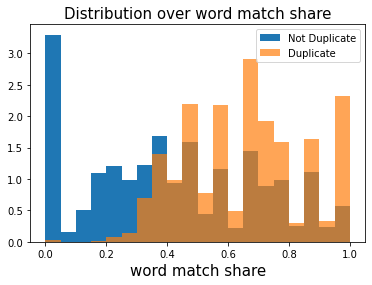

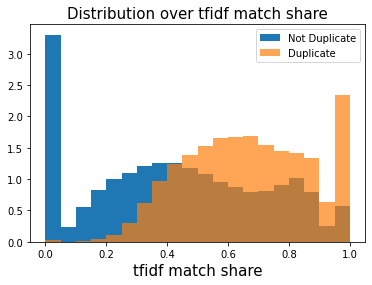

In [0]:
plt.hist(count_features[labels==0], bins=20, density=True, label='Not Duplicate')
plt.hist(count_features[labels==1], bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Distribution over word match share', fontsize=15)
plt.xlabel('word match share', fontsize=15)
plt.show()

plt.hist(tfidf_features[labels==0], bins=20, density=True, label='Not Duplicate')
plt.hist(tfidf_features[labels==1], bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Distribution over tfidf match share', fontsize=15)
plt.xlabel('tfidf match share', fontsize=15)
plt.show()

In [0]:
match_share_features = np.concatenate((count_features, tfidf_features), axis=1)
word_match_shares = ['word_match', 'tfidf_match']

In [0]:
modeling.model_efficiency_xgb(match_share_features, labels)

[0]	train-logloss:0.687141	valid-logloss:0.687947
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.646768	valid-logloss:0.646086
[20]	train-logloss:0.616451	valid-logloss:0.616127
[30]	train-logloss:0.594551	valid-logloss:0.594043
[40]	train-logloss:0.57808	valid-logloss:0.577706
[50]	train-logloss:0.565825	valid-logloss:0.565221
[60]	train-logloss:0.556448	valid-logloss:0.55561
[70]	train-logloss:0.548724	valid-logloss:0.548634
[80]	train-logloss:0.543333	valid-logloss:0.542662
[90]	train-logloss:0.538529	valid-logloss:0.538005
[100]	train-logloss:0.534854	valid-logloss:0.534338
[110]	train-logloss:0.532141	valid-logloss:0.531415
[120]	train-logloss:0.529564	valid-logloss:0.529222
[130]	train-logloss:0.528056	valid-logloss:0.527421
[140]	train-logloss:0.526546	valid-logloss:0.526089
[150]	train-logloss:0.525556	valid-logloss:0.524981
[160]	train-logloss:0.524366	v

({'accuracy': 0.69, 'f1': 0.59, 'loss': 0.52},
 {'accuracy': 0.69, 'f1': 0.59, 'loss': 0.52})

## Concatenation of all features

In [35]:
feature_names = list(features.keys())
print([features[name].shape for name in feature_names])
all_features = np.concatenate([features[name][:,None] for name in feature_names], axis=1)
all_features2 = np.concatenate([features2[name][:,None] for name in feature_names], axis=1)
all_features3 = np.concatenate([features3[name][:,None] for name in feature_names], axis=1)
labels = np.array(is_duplicates)

[(404290,), (404290,), (404290,), (404290,), (404290,), (404290,)]


In [0]:
all_features = np.concatenate((all_features, df_train[basics+fuzzys].values, match_share_features), axis=1)
all_features2 = np.concatenate((all_features2, df_train[basics+fuzzys].values, match_share_features), axis=1)
all_features3 = np.concatenate((all_features3, df_train[basics+fuzzys].values, match_share_features), axis=1)

In [0]:
# np.save('../data/features.npy', all_features)
# np.save('../data/features2.npy', all_features2)
# np.save('../data/features3.npy', all_features3)

# Analyze features

In [0]:
all_features_df = pd.DataFrame(data = all_features, columns=feature_names+basics+fuzzys+word_match_shares)
all_features_df.head()

,SBERT,doc2vec,sent2vec,SIF,Count,TFIDF,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,word_match,tfidf_match
0,0.840102,0.945714,0.909948,0.951283,0.923077,0.802452,66.0,57.0,9.0,20.0,20.0,14.0,12.0,10.0,93.0,95.0,98.0,100.0,89.0,100.0,93.0,0.923077,0.956097
1,0.746924,0.671681,0.069640,0.202860,0.533333,0.419284,51.0,88.0,-37.0,21.0,29.0,8.0,13.0,4.0,66.0,86.0,73.0,100.0,75.0,86.0,63.0,0.533333,0.672097
2,0.891067,0.797049,0.439930,0.763748,0.363636,0.317999,73.0,59.0,14.0,25.0,24.0,14.0,10.0,4.0,54.0,63.0,53.0,100.0,71.0,66.0,66.0,0.363636,0.321940
3,0.281117,0.567116,0.091834,0.049076,0.000000,0.000000,50.0,65.0,-15.0,19.0,26.0,11.0,9.0,0.0,35.0,35.0,30.0,37.0,38.0,36.0,36.0,0.000000,0.000000
4,0.453246,0.655056,0.166427,0.630027,0.266667,0.000000,76.0,39.0,37.0,25.0,18.0,13.0,7.0,2.0,46.0,86.0,54.0,100.0,63.0,67.0,47.0,0.266667,0.267777


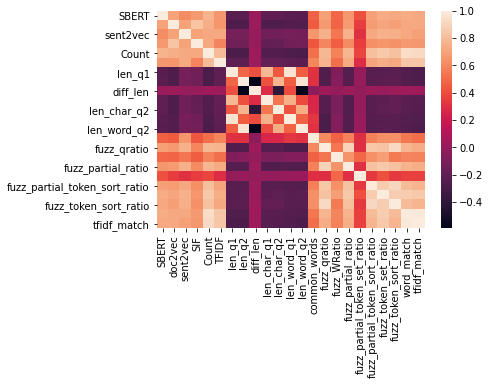

In [0]:
cor = all_features_df.corr()
sns.heatmap(cor)

In [0]:
print((np.array(is_duplicates)==1).sum())
print((np.array(is_duplicates)==0).sum())

149263
255027


# Learning

In [0]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [0]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

X_train, X_valid, y_train, y_valid = all_features[train_index], all_features[valid_index], labels[train_index], labels[valid_index]
# X_train, X_valid, y_train, y_valid = train_test_split(all_features, labels, train_size = 0.7, random_state=42, shuffle=True, stratify=labels)
target_train = y_train
target_valid = y_valid

d_train = xgb.DMatrix(X_train, label=target_train)
d_valid = xgb.DMatrix(X_valid, label=target_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

model = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

proba_predictions_train = model.predict(d_train)
proba_predictions_valid = model.predict(d_valid)

predictions_train = proba_predictions_train >= 0.5
predictions_valid = proba_predictions_valid >= 0.5

loss_train = log_loss(target_train, proba_predictions_train)
loss_valid = log_loss(target_valid, proba_predictions_valid)

accuracy_train = accuracy_score(target_train, predictions_train)
accuracy_valid = accuracy_score(target_valid, predictions_valid)

f1_train = f1_score(target_train, predictions_train)
f1_valid = f1_score(target_valid, predictions_valid)

print({'loss':np.round(loss_train,2), 'accuracy':np.round(accuracy_train,2), 'f1':np.round(f1_train,2)})
print({'loss':np.round(loss_valid,2), 'accuracy':np.round(accuracy_valid,2), 'f1':np.round(f1_valid,2)})

[0]	train-logloss:0.684927	valid-logloss:0.684916
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.621367	valid-logloss:0.621289
[20]	train-logloss:0.575977	valid-logloss:0.575981
[30]	train-logloss:0.542244	valid-logloss:0.54283
[40]	train-logloss:0.517487	valid-logloss:0.518109
[50]	train-logloss:0.498375	valid-logloss:0.498825
[60]	train-logloss:0.483469	valid-logloss:0.483974
[70]	train-logloss:0.471327	valid-logloss:0.472036
[80]	train-logloss:0.461391	valid-logloss:0.462633
[90]	train-logloss:0.453982	valid-logloss:0.455035
[100]	train-logloss:0.447596	valid-logloss:0.448708
[110]	train-logloss:0.442013	valid-logloss:0.443429
[120]	train-logloss:0.437719	valid-logloss:0.439029
[130]	train-logloss:0.434306	valid-logloss:0.435559
[140]	train-logloss:0.431108	valid-logloss:0.432524
[150]	train-logloss:0.428382	valid-logloss:0.429916
[160]	train-logloss:0.426448	

In [0]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

X_train, X_valid, y_train, y_valid = all_features2[train_index], all_features2[valid_index], labels[train_index], labels[valid_index]
target_train = y_train
target_valid = y_valid

d_train = xgb.DMatrix(X_train, label=target_train)
d_valid = xgb.DMatrix(X_valid, label=target_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

model = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

proba_predictions_train = model.predict(d_train)
proba_predictions_valid = model.predict(d_valid)

predictions_train = proba_predictions_train >= 0.5
predictions_valid = proba_predictions_valid >= 0.5

loss_train = log_loss(target_train, proba_predictions_train)
loss_valid = log_loss(target_valid, proba_predictions_valid)

accuracy_train = accuracy_score(target_train, predictions_train)
accuracy_valid = accuracy_score(target_valid, predictions_valid)

f1_train = f1_score(target_train, predictions_train)
f1_valid = f1_score(target_valid, predictions_valid)

print({'loss':np.round(loss_train,2), 'accuracy':np.round(accuracy_train,2), 'f1':np.round(f1_train,2)})
print({'loss':np.round(loss_valid,2), 'accuracy':np.round(accuracy_valid,2), 'f1':np.round(f1_valid,2)})

In [40]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

X_train, X_valid, y_train, y_valid = all_features3[train_index], all_features3[valid_index], labels[train_index], labels[valid_index]
target_train = y_train
target_valid = y_valid

d_train = xgb.DMatrix(X_train, label=target_train)
d_valid = xgb.DMatrix(X_valid, label=target_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

model = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

proba_predictions_train = model.predict(d_train)
proba_predictions_valid = model.predict(d_valid)

predictions_train = proba_predictions_train >= 0.5
predictions_valid = proba_predictions_valid >= 0.5

loss_train = log_loss(target_train, proba_predictions_train)
loss_valid = log_loss(target_valid, proba_predictions_valid)

accuracy_train = accuracy_score(target_train, predictions_train)
accuracy_valid = accuracy_score(target_valid, predictions_valid)

f1_train = f1_score(target_train, predictions_train)
f1_valid = f1_score(target_valid, predictions_valid)

print({'loss':np.round(loss_train,2), 'accuracy':np.round(accuracy_train,2), 'f1':np.round(f1_train,2)})
print({'loss':np.round(loss_valid,2), 'accuracy':np.round(accuracy_valid,2), 'f1':np.round(f1_valid,2)})

[0]	train-logloss:0.681306	valid-logloss:0.681969
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.584651	valid-logloss:0.591167
[20]	train-logloss:0.516074	valid-logloss:0.527552
[30]	train-logloss:0.465684	valid-logloss:0.48145
[40]	train-logloss:0.427799	valid-logloss:0.447241
[50]	train-logloss:0.398814	valid-logloss:0.421305
[60]	train-logloss:0.376341	valid-logloss:0.401466
[70]	train-logloss:0.358639	valid-logloss:0.386148
[80]	train-logloss:0.344665	valid-logloss:0.374383
[90]	train-logloss:0.333406	valid-logloss:0.365073
[100]	train-logloss:0.324317	valid-logloss:0.357814
[110]	train-logloss:0.316898	valid-logloss:0.352014
[120]	train-logloss:0.310901	valid-logloss:0.347449
[130]	train-logloss:0.305936	valid-logloss:0.343803
[140]	train-logloss:0.301881	valid-logloss:0.341071
[150]	train-logloss:0.298369	valid-logloss:0.338653
[160]	train-logloss:0.29532	v